In [1]:
#import libraries
import pandas as pd
from salary_predictions_helper import *

# author info
__author__ = "Ivana Hybenova"
__email__ = "ivana.hybenova1@gmail.com"



### Define parameters to load data and run algorithms

In [2]:
#define input files
data_file = 'data.csv'

#database_credentials = pd.DataFrame({
#    'host': [os.environ['HOST_WAREHOUSE']],
#    'database': [os.environ['NAME_WAREHOUSE']],
#    'user': [os.environ['USER_WAREHOUSE']],
#    'password': [os.environ['PASSWORD_WAREHOUSE']],
#    'engine': [os.environ['ENGINE_WAREHOUSE']]
#})

## SQL query to download jobs table
#sql_query =  """
#               SELECT *
#               FROM jobs
#             """     


#define variables
cat_cols = ['jobType', 'degree', 'major', 'industry']
num_cols = ['yearsExperience', 'milesFromMetropolis']
target_col = 'salary'

#define number of processors to use for parallel runs
num_procs = 4

#set verbose level for models
verbose_lvl = 1

### Create Data object

In [3]:
data = Data(data_file, cat_cols, num_cols, target_col)

Label encoded train dataframe:


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684889669,COMP16,5.0,1.0,102.587732,121.719715,15,60,129
1,JOB1362685279180,COMP30,5.0,4.0,102.587732,130.629367,17,37,141
2,JOB1362685380312,COMP31,3.0,1.0,102.587732,130.629367,3,36,121
3,JOB1362685069975,COMP55,7.0,3.0,102.587732,104.417309,6,67,130
4,JOB1362684831217,COMP6,1.0,4.0,128.974052,99.431658,15,90,94



Label encoded validate dataframe:


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684684513,COMP16,1.0,1.0,102.587732,115.786735,0,37,64
1,JOB1362685257112,COMP60,3.0,1.0,102.587732,130.629367,23,22,176
2,JOB1362684912186,COMP8,2.0,4.0,130.335835,121.719715,13,37,128
3,JOB1362685008741,COMP34,5.0,0.0,102.587732,99.431658,23,98,81
4,JOB1362685387908,COMP47,3.0,0.0,102.587732,130.629367,10,47,93


### Generate new features

In [4]:
feature_generator = FeatureGenerator(data)
feature_generator.add_group_stats()

Train dataframe with group stats:


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,group_mean,group_max,group_min,group_std,group_median
0,JOB1362684889669,COMP16,5.0,1.0,102.587732,121.719715,15,60,129,129.822748,223,70,27.529276,127.0
1,JOB1362685279180,COMP30,5.0,4.0,102.587732,130.629367,17,37,141,156.910072,244,95,29.972235,156.0
2,JOB1362685380312,COMP31,3.0,1.0,102.587732,130.629367,3,36,121,119.141943,213,62,26.990595,116.0
3,JOB1362685069975,COMP55,7.0,3.0,102.587732,104.417309,6,67,130,134.245614,202,77,26.309025,130.0
4,JOB1362684831217,COMP6,1.0,4.0,128.974052,99.431658,15,90,94,89.454874,152,48,22.955746,86.0



Validate dataframe with group stats:


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,group_mean,group_max,group_min,group_std,group_median
0,JOB1362684684513,COMP16,1.0,1.0,102.587732,115.786735,0,37,64,84.420679,169,38,23.008740,80.0
1,JOB1362685257112,COMP60,3.0,1.0,102.587732,130.629367,23,22,176,119.141943,213,62,26.990595,116.0
2,JOB1362684912186,COMP8,2.0,4.0,130.335835,121.719715,13,37,128,128.884477,215,82,25.513729,128.0
3,JOB1362685008741,COMP34,5.0,0.0,102.587732,99.431658,23,98,81,105.211963,197,52,25.676940,102.0
4,JOB1362685387908,COMP47,3.0,0.0,102.587732,130.629367,10,47,93,115.138192,217,56,26.046075,113.0


### Defome algorithms to try and their hyper parameters

In [5]:
#create model containers
models = ModelContainer()

# hyper parameters
# Random Forest hyperparameters
dt_hyperparameters = {
    'max_depth': [7, 10, 15],
    'min_samples_leaf': [5, 15, 50]
}
    
# Random Forest hyperparameters
rf_hyperparameters = {
    'n_estimators': [50, 100, 500, 1000],
    'max_features': ['auto',  0.33],
    'max_depth': [7, 10, 15],
    'min_samples_leaf': [5, 15, 50]
    
}

# Boosted Tree hyperparameters
gb_hyperparameters = {
    'n_estimators': [50],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5, 7]
}



#add models to train
models.add_model(DecisionTreeRegressor(max_depth = 7, max_features = 3, random_state = 0), dt_hyperparameters)
models.add_model(RandomForestRegressor(n_jobs=num_procs,  max_depth = 5, max_features = 3, verbose=verbose_lvl, random_state = 0), rf_hyperparameters)
models.add_model(GradientBoostingRegressor(n_estimators = 50, max_depth = 3, loss='ls', verbose=verbose_lvl, random_state = 0), gb_hyperparameters)

### Cross validate the models and select best one

      Iter       Train Loss   Remaining Time 
         1        1334.4052           52.78s
         2        1199.5018           50.67s
         3        1083.6607           48.81s
         4         989.1754           48.42s
         5         907.6085           46.84s
         6         837.7325           45.71s
         7         778.5556           44.55s
         8         725.9761           43.47s
         9         681.9169           42.29s
        10         643.2651           41.46s
        20         448.7350           32.16s
        30         390.1421           21.75s
        40         368.6981           10.78s
        50         360.3996            0.00s

Model Summaries:


 DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=3,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      pre

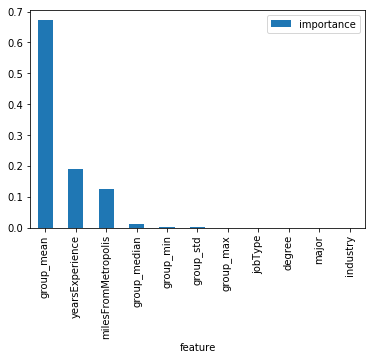

Best model MSE on validation test is:  363.07573139011646
Best model MAE on validation test is:  15.450293438151945
Best model R^2 on validation test is:  0.7577977142219429


In [6]:
models.cross_validate(data, k=3, num_procs=num_procs)
models.select_best_model()
models.best_model_fit(data.train_df[data.feature_cols], data.train_df[data.target_col])
models.print_summary(data)
models.validate_best_model(data)

### Update the list of predictors based on features importance and tune the best model

In [7]:
# update the features with selected features only and tune the model
selected_features = ['group_mean', 'yearsExperience', 'milesFromMetropolis', 'group_median']
data.update_feature_cols(selected_features)

## Uncomment to run the tuning process
#models.tune_best_model(data)
#models.validate_best_model(data)
#models.best_model.best_params_

### Create a new ModelContainer with the best model and best parameters

In [8]:
# create mew model container with tuned model
models_tuned = ModelContainer()
models_tuned.add_model(GradientBoostingRegressor(n_estimators = 50, max_depth = 5, learning_rate = 0.1, loss='ls', verbose=verbose_lvl, random_state = 0), None)

### Cross validate the tuned model, fit it to the data and validate

      Iter       Train Loss   Remaining Time 
         1        1301.3241           57.89s
         2        1140.1962           55.52s
         3        1006.6247           53.59s
         4         896.2999           52.07s
         5         805.4922           52.17s
         6         730.4800           50.98s
         7         667.8132           52.59s
         8         616.5339           51.46s
         9         573.6010           50.04s
        10         537.9390           48.89s
        20         387.9826           36.41s
        30         360.6632           23.61s
        40         354.9324           11.72s
        50         353.5556            0.00s
Best model MSE on validation test is:  356.9346507598688
Best model MAE on validation test is:  15.337305236440134
Best model R^2 on validation test is:  0.7618943354973405

Model Summaries:


 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', 

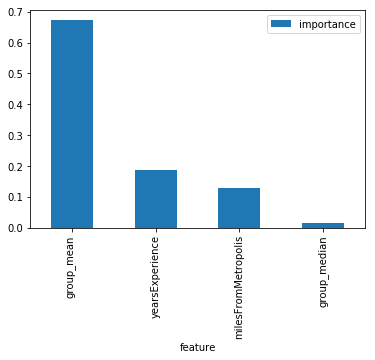

In [10]:
models_tuned.cross_validate(data, k=3, num_procs=num_procs)
models_tuned.select_best_model()
models_tuned.best_model_fit(data.train_df[data.feature_cols], data.train_df[data.target_col])
models_tuned.validate_best_model(data)
models_tuned.print_summary(data)

### Save the label encoders, generated features, selected features and the model

In [78]:
save_model(data, feature_generator, models_tuned)